---
title: NonLinear Shallow Water Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: NonLinear SWM
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.models.sw import Params as SWMParams, State as SWMState

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)




Taking the equation from [wikipedia](https://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form).

**Non-Conservative Form**

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ 
\frac{\partial}{\partial x}\left((H+h)u\right) +
\frac{\partial}{\partial y}\left((H+h)v\right)= 0 \\
\frac{\partial u}{\partial t} &+ u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} - fv =
-g\frac{\partial h}{\partial x} -ku + \nu \left( \frac{\partial^2 u}{\partial x^2} + 
\frac{\partial^2 u}{\partial y^2} \right)\\
\frac{\partial v}{\partial t} &+ u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + fu =
-g\frac{\partial h}{\partial y} -kv + 
\nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)\\
\end{aligned}
$$ (eq:sw)

| Symbol | Variable | Unit | 
|:---------:|:------|:----:|
| $u$ | Zonal Velocity |  $m/s^2$ |
| $v$ | Meridial Velocity |   $m/s^2$ |
| $H$ |Mean Height |   $m$ |
| $h$ |Height Deviation |$m$ |
|$b$ | Topographical height 


**Velocities**. The $u,v$ represent the zonal and meridional velocities in the x,y directions respectively.

**Heights** ($H,h,b$). 
The $H$ represents the mean hight of the horizontal pressure surface. 
The $h$ represents the height deviation of the horizontal pressure surface from its mean height.
$b$ represents the topographical height from a reference $D$.

$$
\begin{aligned}
\eta(x,y,t) &= H(x,y) + h(x,y,t) \\
H(x,y) &= D + b(x,y)
\end{aligned}
$$

**Constants** ($f,k,\nu$). $g$ is the acceleration due to gravity, $k$ is the viscous drag coefficient, and $\nu$ is the kinematic viscosity.

**NonLinear SW Example**

* Varying Coriolis Force
* NonLinear Terms
* Lateral Friction
* Periodic Boundary Conditions

## Domain



In [2]:
dx = dy = 5e3
Lx = 200 * dx
Ly = 104 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume:_}")

Nx: (201, 105)
Lx: (1000000.0, 520000.0)
dx: (5000.0, 5000.0)
Size: (201, 105)
nDims: 2
Grid Size: (201, 105, 2)
Cell Volume: 25_000_000.0


## State + Parameters

In [3]:
params = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)

## Initial Condition

In [4]:
def init_u0(params):
    domain = params.domain
    # grab coordinate values
    y = domain.coords[1]
    # grab grid coordinate values
    Y = domain.grid[..., 1]
    # grab number of points - y direction
    n_y = domain.Nx[1]
    # grabs physical length of domain - x direction
    l_x = domain.Lx[0]
    # makes a Gaussian Ridge?
    u0 = 10 * np.exp(-((Y - y[n_y // 2]) ** 2) / (0.02 * l_x) ** 2)

    return jnp.asarray(u0)


def init_h0(params):
    domain = params.domain
    # parse parameters and domain
    dy = domain.dx[1]
    coriolis_param = params.coriolis_param(domain)
    gravity = params.gravity
    depth = params.depth

    # grab grid coordinate values
    X, Y = domain.grid[..., 0], domain.grid[..., 1]

    # grab number of points - y direction
    n_y = domain.Nx[1]

    # grabs physical length of domain - x direction
    l_x, l_y = domain.Lx

    u0 = init_u0(params)

    # approximate balance h_y = -(f/g)u
    h0 = jnp.cumsum(-dy * u0 * coriolis_param / gravity, axis=1)

    # remove mean (make sure h0 is centered around depth)
    h0 -= h0.mean()

    # add depth
    h0 += depth

    # add small perturbation
    h0 += 0.2 * jnp.sin(X / l_x * 10 * jnp.pi) * jnp.cos(Y / l_y * 8 * jnp.pi)

    # boundaries of H must not be used!
    h0 = h0.at[0, :].set(jnp.nan)
    h0 = h0.at[-1, :].set(jnp.nan)
    h0 = h0.at[:, 0].set(jnp.nan)
    h0 = h0.at[:, -1].set(jnp.nan)

    return jnp.asarray(h0)

In [5]:
params = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)


h0 = init_h0(params)
u0 = init_u0(params)

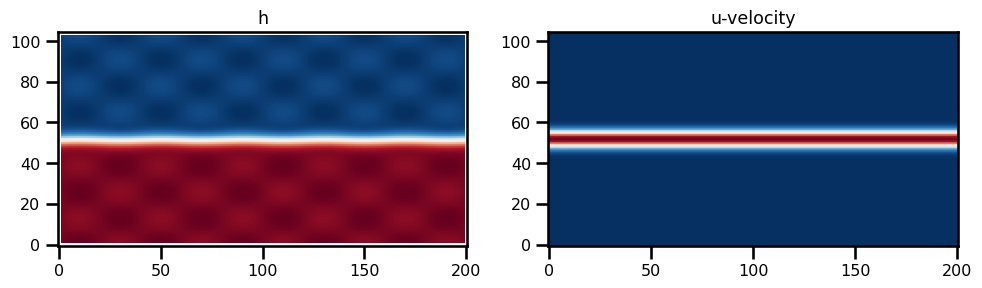

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(h0.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u0.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

plt.tight_layout()
plt.show()

### State Revisited

In [7]:
from jaxtyping import Array


class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h0, init_u0):
        h = init_h0(domain, params)
        v = jnp.zeros_like(h)
        u = init_u0(domain)
        return cls(u=u, v=v, h=h)

In [8]:
ds_results = xr.load_dataset("./sw_nonlinear_jet.nc")

In [9]:
state_init = SWMState.init_state(params, init_h=init_h0, init_u=init_u0)

state_init = SWMState(
    u=jnp.asarray(ds_results.u.isel(time=-1)),
    v=jnp.asarray(ds_results.v.isel(time=-1)),
    h=jnp.asarray(ds_results.h.isel(time=-1)),
)

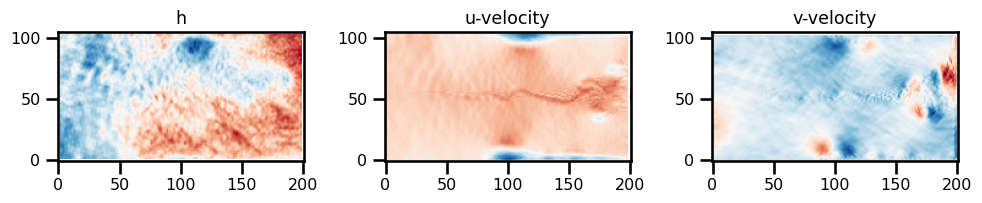

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(state_init.h.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(state_init.u.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(state_init.v.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

## Boundary Conditions

**Period Case**:

* h, u, v - periodic in x
* v - northern boundary as zero

**NonPeriodic Case**:

* h - nothing
* u - east boundary as zero
* v - northern boundary as zero

In [11]:
def enforce_boundaries(u, grid: str, periodic_x: bool = False):
    assert grid in ["h", "u", "v"]

    if periodic_x:
        u = u.at[0, :].set(u[-2, :])
        u = u.at[-1, :].set(u[1, :])

    elif grid == "u":
        u = u.at[-2, :].set(0.0)

    if grid == "v":
        u = u.at[:, -2].set(0.0)

    return u

In [12]:
u_bc = enforce_boundaries(u0, "u", False)
u_bc_periodic = enforce_boundaries(u0, "u", True)

h_bc = enforce_boundaries(h0, "h", False)
h_bc_periodic = enforce_boundaries(h0, "h", True)

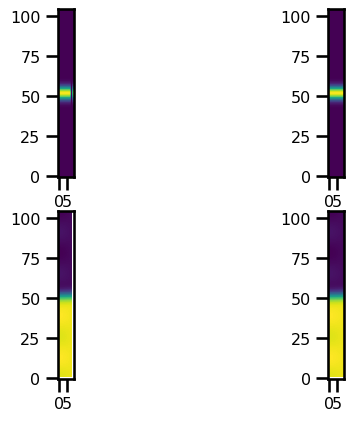

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(u_bc[-10:].T, origin="lower")
ax[0, 1].imshow(u_bc_periodic[-10:].T, origin="lower")
ax[1, 0].imshow(h_bc[-10:].T, origin="lower")
ax[1, 1].imshow(h_bc_periodic[-10:].T, origin="lower")

plt.show()

### Height Equation

Remember [](#eq:sw) 

### U-Velocity

Remember [](#eq:sw) 

**Note**: written in *vector invariant momentum* form ([see MITGCM manual](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations) | [Wikipedia](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Compressible_flow))

**TODO**: Is there any advantage to this?

$$
\begin{aligned}
\text{Potential Vorticity}: && 
\frac{\text{Planetary Vort} + \text{Relative Vort.}}{\text{Height}}
\\
\text{Planetary Vorticity}: && f \\
\text{Relative Vorticity}: && \partial_x v - \partial_y u \\
\end{aligned}
$$


### V-Velocity

In [18]:
def print_diagnostics(u):
    print(u.min(), u.max(), u.mean(), np.median(u))


def equation_of_motion(state, params):
    h, u, v = state.h, state.u, state.v

    h = enforce_boundaries(h, "h", False)
    v = enforce_boundaries(v, "v", False)
    u = enforce_boundaries(u, "u", False)

    # pad
    # print("Ghost")
    h_node = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    h_node = enforce_boundaries(h_node, "h", False)

    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # print("H --> U,V")
    h_on_u = 0.5 * (h_node[1:-1, 1:-1] + h_node[2:, 1:-1])

    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    h_on_v = 0.5 * (h_node[1:-1, 1:-1] + h_node[1:-1, 2:])

    # print_diagnostics(h_on_u)
    # print_diagnostics(h_on_v)

    # hu, hv (interior only)
    # print("HU --> U,V")
    flux_on_u = jnp.zeros_like(h)
    flux_on_v = jnp.zeros_like(h)
    flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])
    flux_on_v = flux_on_v.at[1:-1, 1:-1].set(h_on_v * v[1:-1, 1:-1])

    flux_on_u = enforce_boundaries(flux_on_u, "h", False)
    flux_on_v = enforce_boundaries(flux_on_v, "h", False)

    # finite difference
    # print("DH")
    # u --> h | top edge --> cell node | right edge --> cell center
    dh_dx = (flux_on_u[1:-1, 1:-1] - flux_on_u[:-2, 1:-1]) / domain.dx[0]
    # v --> h | right edge --> cell node | top edge --> cell center
    dh_dy = (flux_on_v[1:-1, 1:-1] - flux_on_v[1:-1, :-2]) / domain.dx[1]

    # print_diagnostics(dh_dx)
    # print_diagnostics(dh_dy)

    # print("H_RHS")
    h_rhs = jnp.zeros_like(h)
    h_rhs = h_rhs.at[1:-1, 1:-1].set(-(dh_dx + dh_dy))
    # print_diagnostics(h_rhs)

    # planetary and relative vorticity
    # print("PLANETARY VORTICITY")
    planetary_vort = params.coriolis_param(domain)[1:-1, 1:-1]

    # relative vorticity
    # print("dv_dx | du_dy")
    # v --> q | right edge --> cell face | top edge --> cell node
    dv_dx = (v[2:, 1:-1] - v[1:-1, 1:-1]) / domain.dx[0]
    # u --> q | top edge --> cell face | right edge --> cell node
    du_dy = (u[1:-1, 2:] - u[1:-1, 1:-1]) / domain.dx[1]

    # print_diagnostics(dv_dx)
    # print_diagnostics(du_dy)

    # print("RELATIVE VORTICITY")
    relative_vort = dv_dx - du_dy

    # print_diagnostics(relative_vort)

    #     print_diagnostics(dv_dx)
    #     print_diagnostics(du_dy)

    # calculate potential vorticity

    # h --> q | cell node --> cell face | cell face --> cell node
    # move h (cell node) to vort (cell center)
    # print("H --> VORTICITY")
    h_on_vort = 0.25 * (
        h_node[1:-1, 1:-1] + h_node[2:, 1:-1] + h_node[1:-1, 2:] + h_node[2:, 2:]
    )

    # print_diagnostics(h_on_vort)

    # print("Potential VORTICITY")
    potential_vort = jnp.zeros_like(h)
    potential_vort = potential_vort.at[1:-1, 1:-1].set(
        (planetary_vort + relative_vort) / h_on_vort
    )

    # enforce boundaries
    potential_vort = enforce_boundaries(potential_vort, "h", False)

    # print_diagnostics(potential_vort)

    # print_diagnostics(potential_vort)

    # flux on v (top edge) ---> vort (cell center)
    # v --> q | | right edge --> cell face | top edge --> cell node
    # print("HV --> Q")
    flux_on_q_l = 0.5 * (flux_on_v[1:-1, 1:-1] + flux_on_v[2:, 1:-1])

    # v --> q | | right edge --> cell face | top edge --> cell node
    flux_on_q_r = 0.5 * (flux_on_v[1:-1, :-2] + flux_on_v[2:, :-2])

    # print_diagnostics(flux_on_q_l)
    # print_diagnostics(flux_on_q_r)

    # advection
    # q--> u | cell face --> top edge |  cell node --> right edge

    # print("ADV RHS ---> U")
    adv_rhs = 0.5 * (
        potential_vort[1:-1, 1:-1] * flux_on_q_l
        + potential_vort[1:-1, :-2] * flux_on_q_r
    )

    # print_diagnostics(adv_rhs)
    # print_diagnostics(adv_rhs)

    # kinetic energy
    # print("U2, V2 ---> H")
    ke_on_h = jnp.zeros_like(h)

    # u --> h | top edge --> cell node | right edge --> cell center
    u2_on_h = 0.5 * (u[1:-1, 1:-1] ** 2 + u[:-2, 1:-1] ** 2)
    # v --> h | right edge --> cell node | top edge --> cell center
    v2_on_h = 0.5 * (v[1:-1, 1:-1] ** 2 + v[1:-1, :-2] ** 2)

    # print_diagnostics(u2_on_h)
    # print_diagnostics(v2_on_h)
    # print("KE ---> H")

    ke_on_h = ke_on_h.at[1:-1, 1:-1].set(0.5 * (u2_on_h + v2_on_h))

    # enforce boundary conditions
    ke_on_h = enforce_boundaries(ke_on_h, "h", False)
    # print_diagnostics(ke_on_h)

    # print("KE ---> U")
    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    dke_on_u = -(ke_on_h[2:, 1:-1] - ke_on_h[1:-1, 1:-1]) / domain.dx[0]

    # print_diagnostics(dke_on_u)

    # pressure work
    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # print("p work")
    p_work = -params.gravity * (h[2:, 1:-1] - h[1:-1, 1:-1]) / domain.dx[0]

    # print_diagnostics(p_work[1:-1,1:-1])

    u_rhs = jnp.zeros_like(h)
    u_rhs = u_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_u)

    # u --> q | top edge --> cell face | right edge --> cell node
    # print("HU --> Q")
    flux_on_q_l = 0.5 * (flux_on_u[1:-1, 1:-1] + flux_on_u[1:-1, 2:])

    # u --> q | top edge --> cell face | right edge --> cell node
    flux_on_q_r = 0.5 * (flux_on_u[:-2, 1:-1] + flux_on_u[:-2, 2:])

    # print_diagnostics(flux_on_q_r)

    # advection
    # q --> v | cell face --> right edge | cell node --> top edge
    # print("ADV RHS")
    adv_rhs = -0.5 * (
        potential_vort[1:-1, 1:-1] * flux_on_q_l
        + potential_vort[:-2, 1:-1] * flux_on_q_r
    )

    # print_diagnostics(adv_rhs)

    # print("DKE ---> v")

    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    dke_on_v = -(ke_on_h[1:-1, 2:] - ke_on_h[1:-1, 1:-1]) / domain.dx[1]

    # print_diagnostics(dke_on_v)

    # pressure work
    # print("p work")
    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    p_work = -params.gravity * (h[1:-1, 2:] - h[1:-1, 1:-1]) / domain.dx[1]

    # print(h.shape, p_work.shape)

    # print_diagnostics(p_work[1:-1,1:-1])

    v_rhs = jnp.zeros_like(h)
    v_rhs = v_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_v)

    return h_rhs, u_rhs, v_rhs

In [19]:
h_rhs, u_rhs, v_rhs = equation_of_motion(state_init, params)

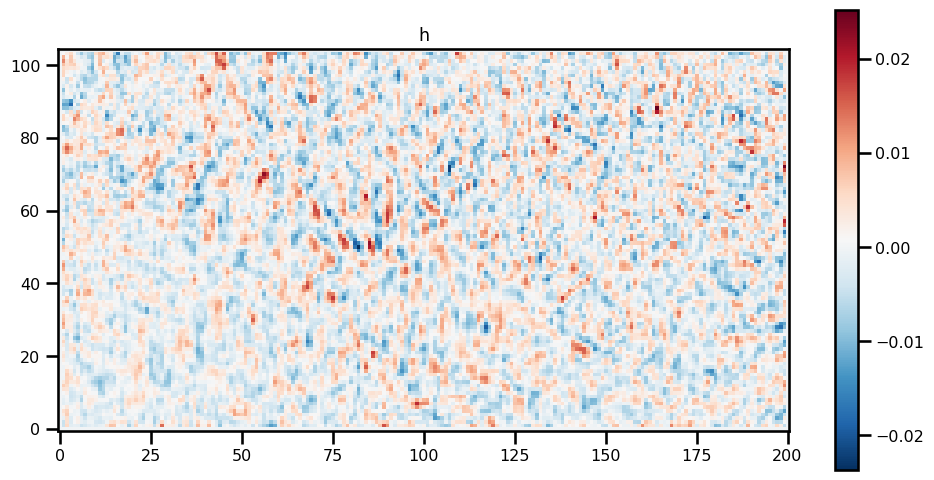

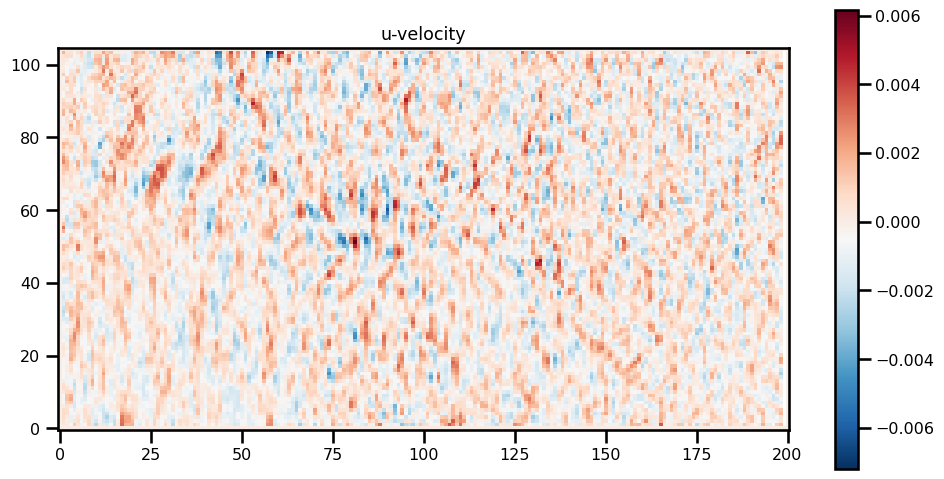

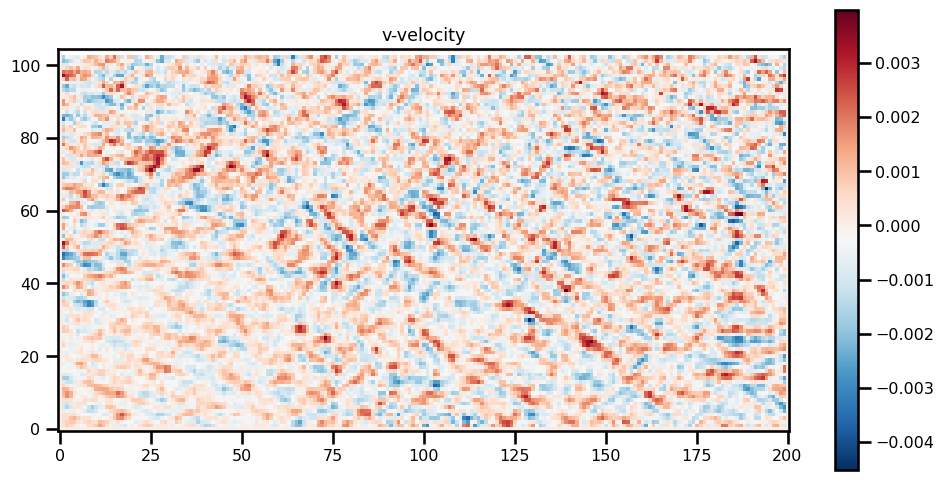

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
pts = ax.imshow(h_rhs.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
ax.set(title="h")


plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
pts = ax.imshow(u_rhs.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
ax.set(title="u-velocity")


plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
pts = ax.imshow(v_rhs.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
ax.set(title="v-velocity")


plt.tight_layout()
plt.show()

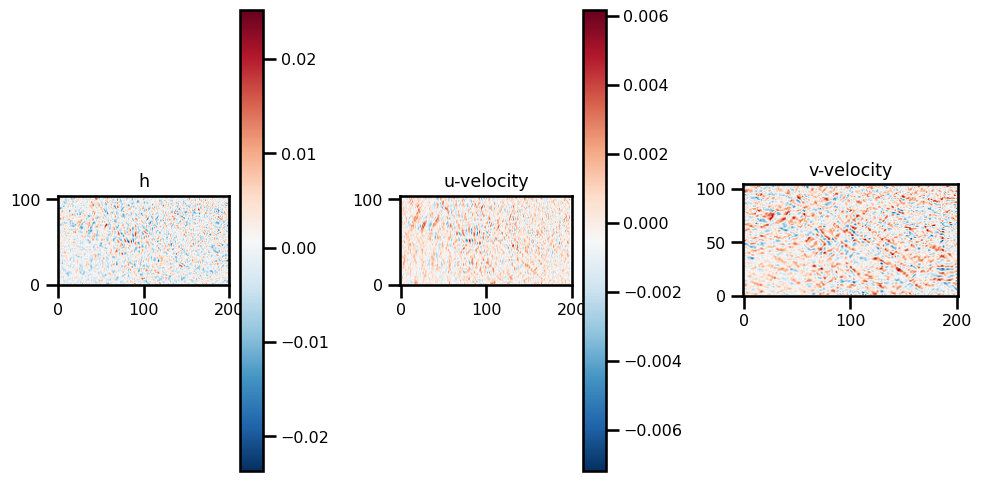

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
pts = ax[0].imshow(h_rhs.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
ax[0].set(title="h")

pts = ax[1].imshow(u_rhs.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
ax[1].set(title="u-velocity")

ax[2].imshow(v_rhs.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

## Equation of Motion

In [22]:
class ShallowWater2D(DynamicalSystem):
    @staticmethod
    def boundary_f(state, component: str = "h"):
        if component == "h":
            return state
        elif component == "u":
            u = state.u.at[-2, :].set(jnp.asarray(0.0))
            return eqx.tree_at(lambda x: x.u, state, u)
        elif component == "v":
            v = state.v.at[:, -2].set(jnp.asarray(0.0))
            return eqx.tree_at(lambda x: x.v, state, v)
        else:
            msg = f"Unrecognized component: {component}"
            msg += "\nNeeds to be h, u, or v"
            raise ValueError(msg)

    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Linear Shallow Water Equations

        Equation:
            ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
            ∂u/∂t - fv = - g ∂h/∂x - ku
            ∂v/∂t + fu = - g ∂h/∂y - kv
        """

        # apply boundary conditions
        state = ShallowWater2D.boundary_f(state, "h")
        state = ShallowWater2D.boundary_f(state, "u")
        state = ShallowWater2D.boundary_f(state, "v")

        # # apply RHS
        # h_rhs = equation_of_motion_h(state, args)
        # v_rhs = equation_of_motion_v(state, args)
        # u_rhs = equation_of_motion_u(state, args)
        h_rhs, u_rhs, v_rhs = equation_of_motion(state, args)

        # update state
        state = eqx.tree_at(lambda x: x.u, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v, state, v_rhs)
        state = eqx.tree_at(lambda x: x.h, state, h_rhs)

        # # apply boundary conditions
        # state = LinearShallowWater2D.boundary_f(state, "h")
        # state = LinearShallowWater2D.boundary_f(state, "u")
        # state = LinearShallowWater2D.boundary_f(state, "v")
        return state

In [23]:
state_update = ShallowWater2D.equation_of_motion(0, state_init, params)

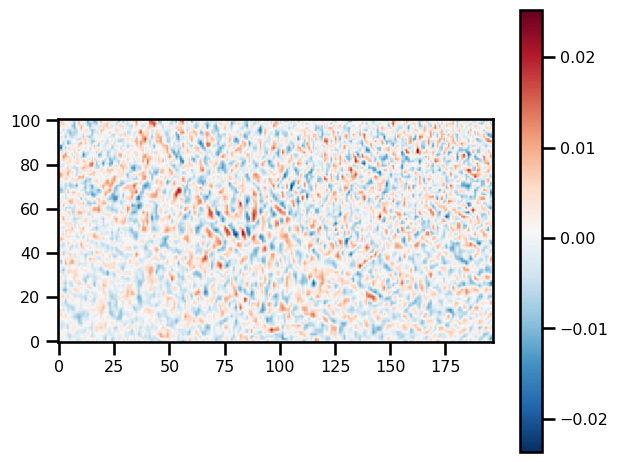

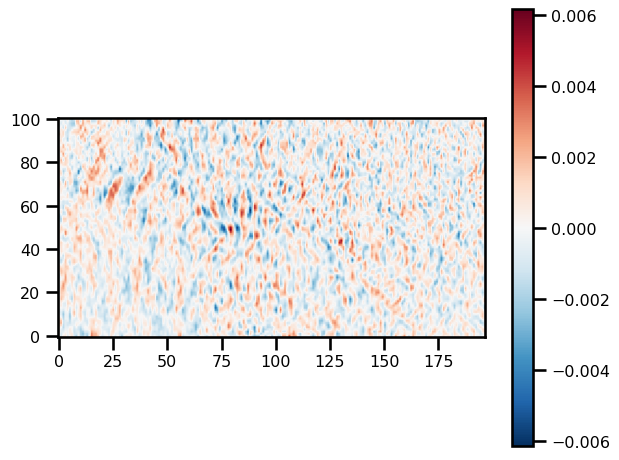

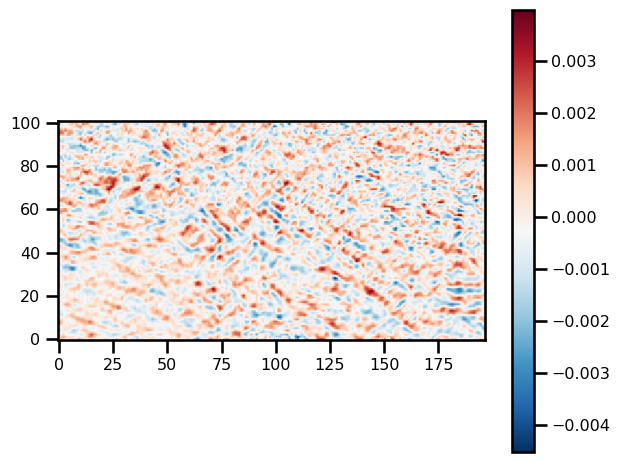

In [24]:
fig, ax = plt.subplots()

pts = ax.imshow(state_update.h[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

pts = ax.imshow(state_update.u[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

pts = ax.imshow(state_update.v[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Time Stepping

In [37]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.125 * min(domain.dx[0], domain.dx[1]) / np.asarray(params.phase_speed)
print(f"Step Size (dt): {pd.to_timedelta(dt, unit='second')}")

tmin = 0.0
tmax = pd.to_timedelta(0.5, unit="days").total_seconds()
num_save = 20

Step Size (dt): 0 days 00:00:19.954714275


In [38]:
pd.to_timedelta(dt, unit="seconds")

Timedelta('0 days 00:00:19.954714275')

In [39]:
import pandas as pd

In [40]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = ShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [41]:
%%time
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()
# rtol = 1e-3
# atol = 1e-4
# stepsize_controller = dfx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dt
# )

# SPATIAL DISCRETIZATION
params_init = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)
state_init = SWMState.init_state(params_init, init_h=init_h0, init_u=init_u0)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 5.74 s, sys: 116 ms, total: 5.85 s
Wall time: 5.49 s


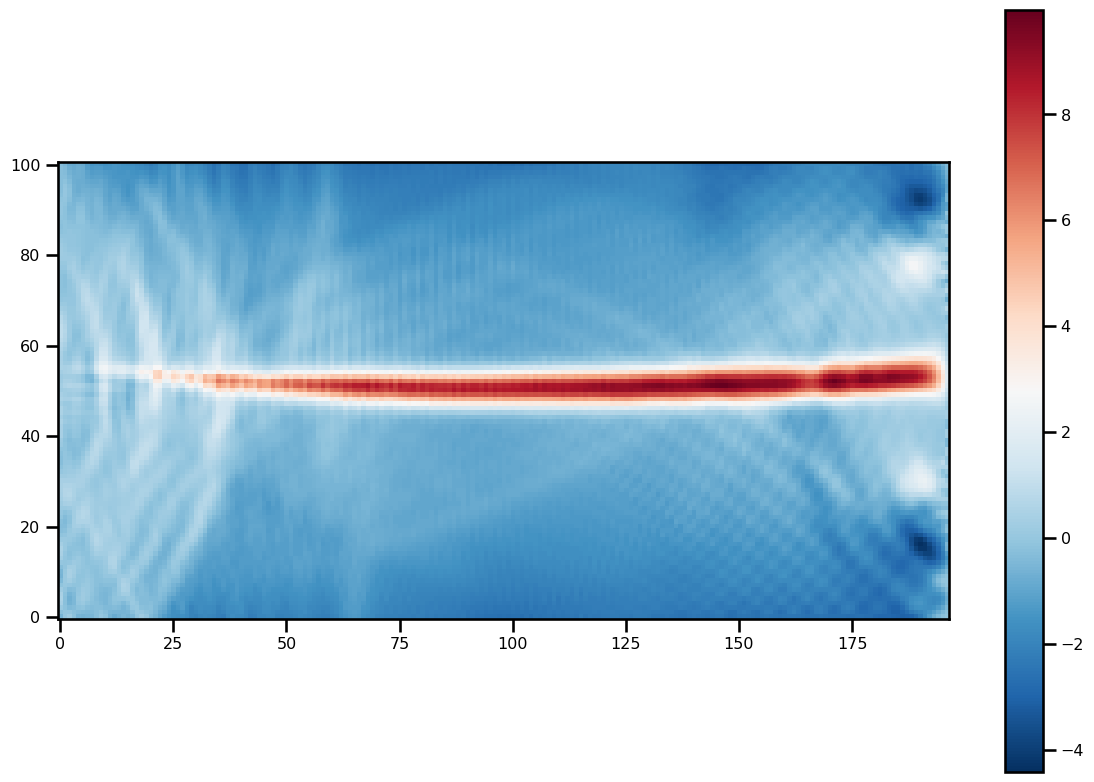

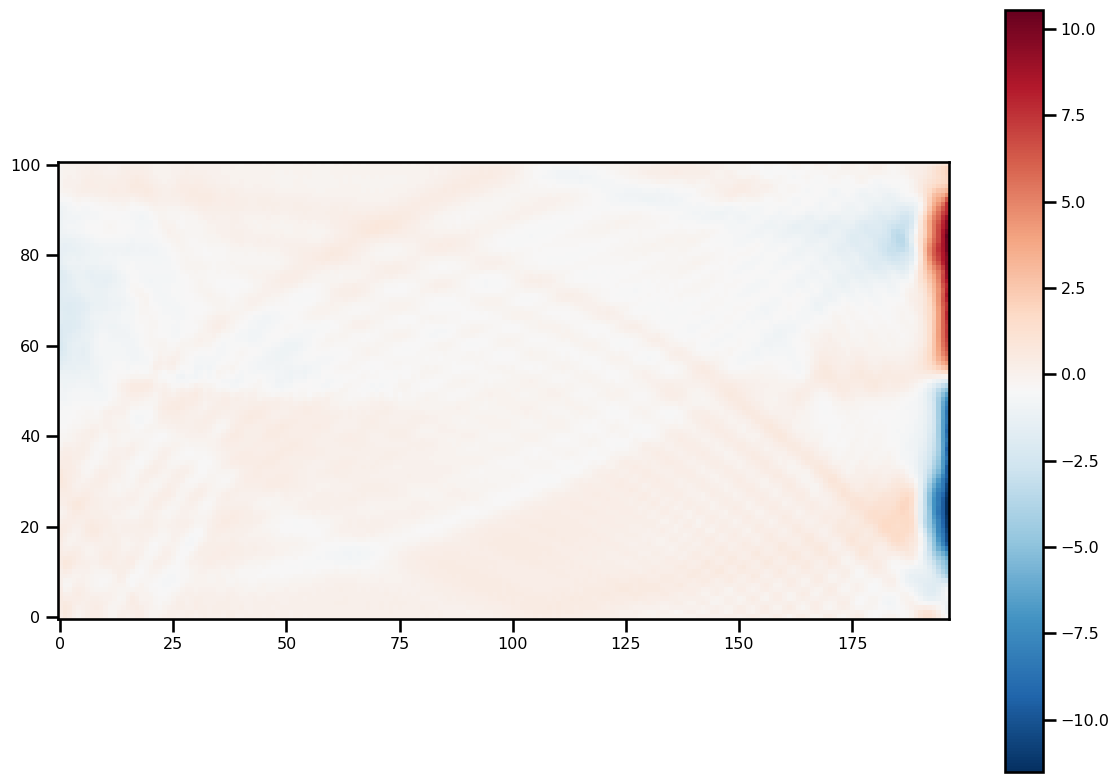

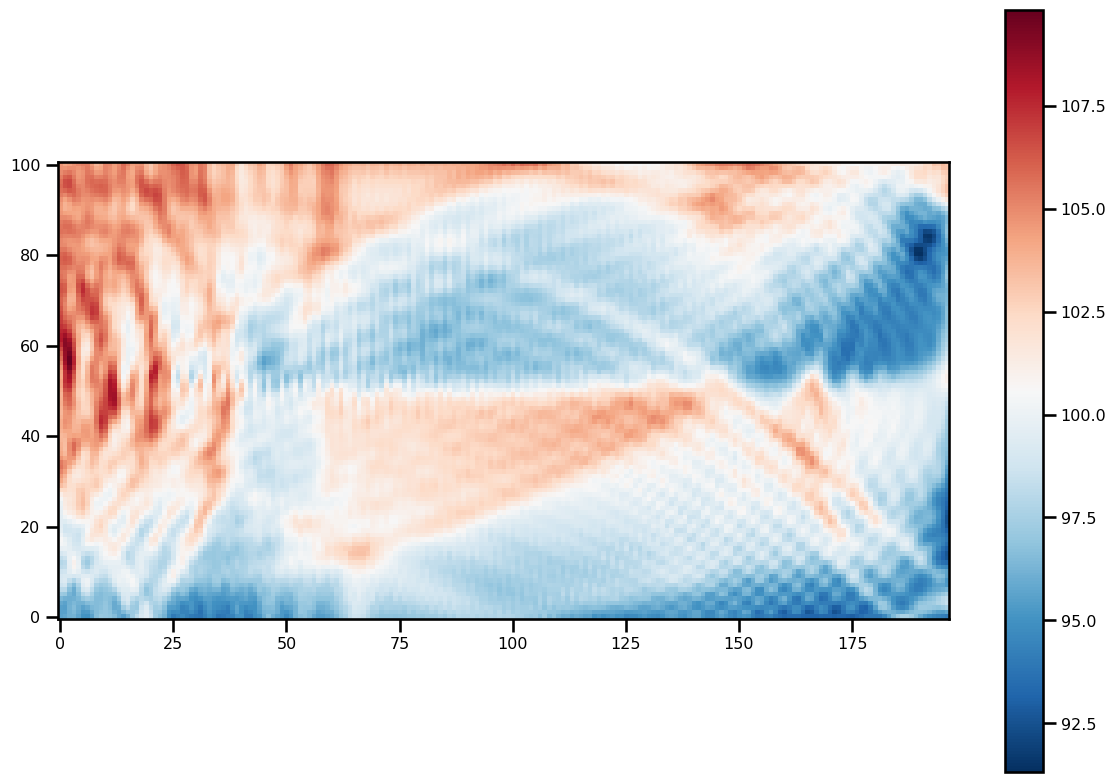

In [43]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1][2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [34]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u),
        "v": (("time", "x", "y"), sol.ys.v),
        "h": (("time", "x", "y"), sol.ys.h),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), domain.coords[0]),
        "y": (("y"), domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 60, x: 201, y: 105)
Coordinates:
  * time     (time) float64 0.0 2.929e+03 5.858e+03 ... 1.699e+05 1.728e+05
  * x        (x) float64 0.0 5e+03 1e+04 1.5e+04 ... 9.9e+05 9.95e+05 1e+06
  * y        (y) float64 0.0 5e+03 1e+04 1.5e+04 ... 5.1e+05 5.15e+05 5.2e+05
Data variables:
    u        (time, x, y) float64 4.02e-73 2.512e-70 ... 2.512e-70 4.02e-73
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 nan nan nan nan nan ... nan nan nan nan nan

In [35]:
ds_results.to_netcdf("./sw_nonlinear_jet.nc")

In [48]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 4.5)

    ax = fig.subplots(
        ncols=3,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "U-Velocity [ms$^{-1}$]"}
    vmin = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).min()
    vmax = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).max()
    pts = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[1],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # V-VELOCITY
    cbar_kwargs = {"label": "V-Velocity [ms$^{-1}$]"}
    vmin = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).min()
    vmax = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).max()
    pts = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[2],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.contour(
        ax=ax[2],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')

    pts = ax[2].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(10, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    sub["ke"] = np.sqrt(0.5 * (sub.u**2 + sub.v**2))
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-1}$]"}
    vmin = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).min()
    vmax = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).max()
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

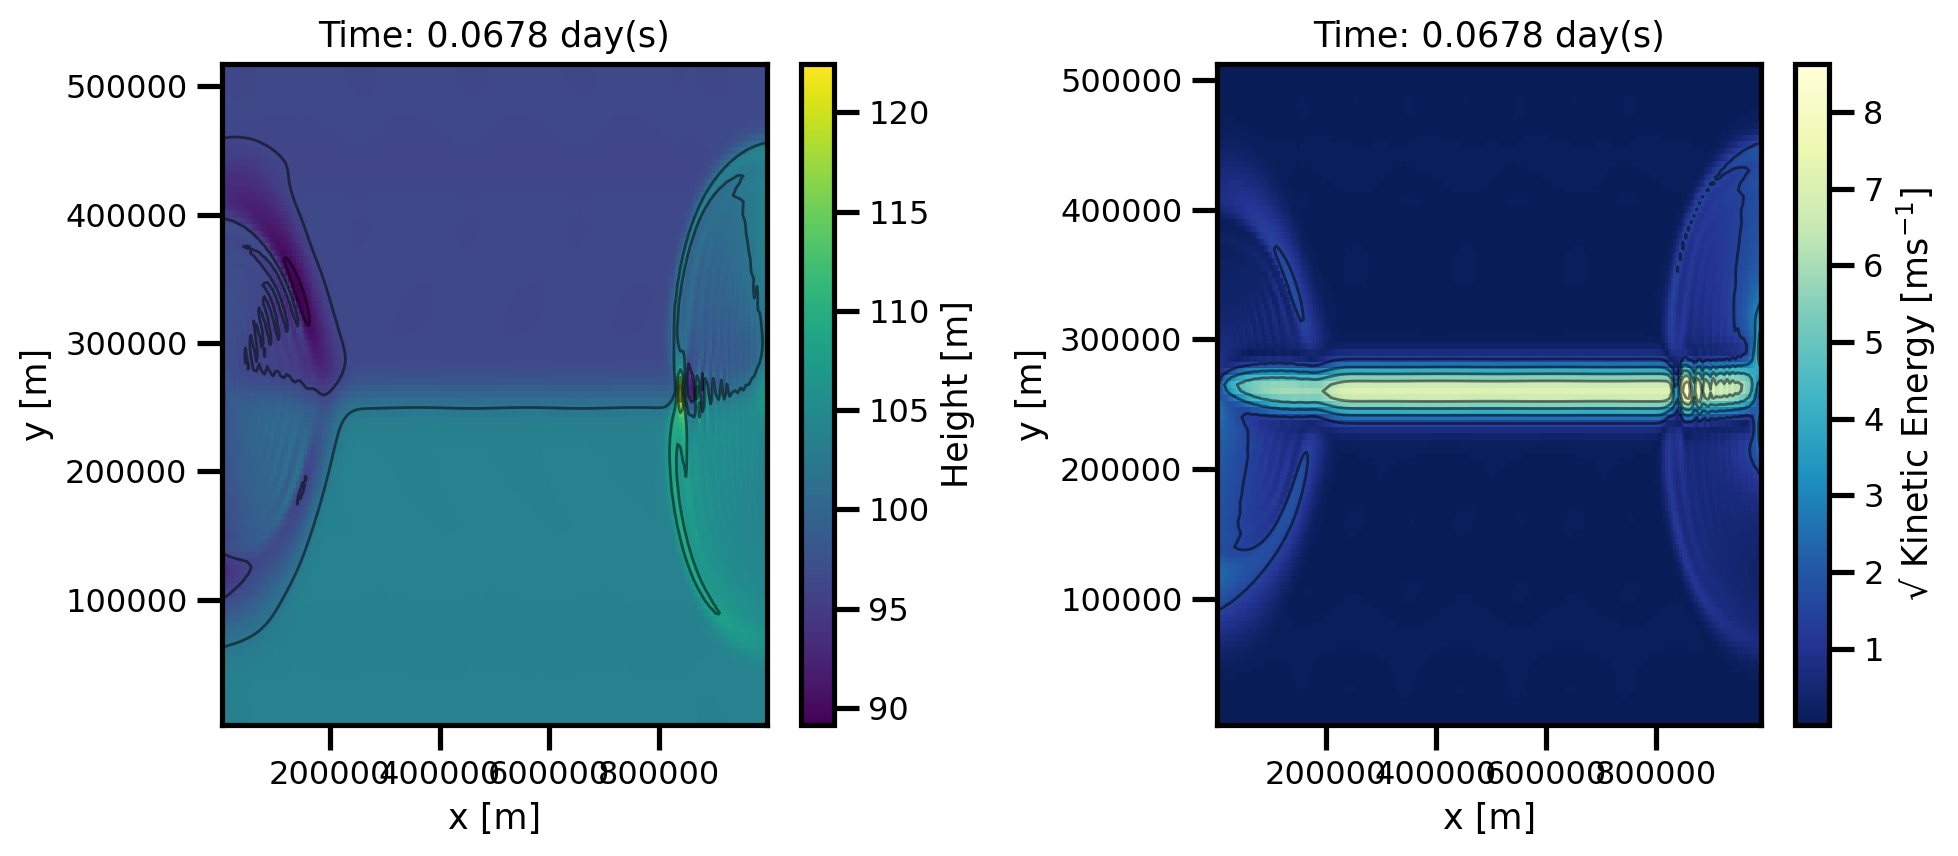

In [52]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
)
mov.preview(2)

In [53]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="swe_nonlinear_jet",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at movie_swe_nonlinear_jet.mp4
GIF created at movie_swe_nonlinear_jet.gif
